# GLEAM: Model Configuration & Usage Guide

Below is the breakdown of the pipeline configuration:

### 1. What is the Input?
The model requires **two `AnnData` objects** (one for each modality) that share the same observations (cells) or have been integrated into a shared manifold.
* **`adata_rna`**: Single-cell Gene Expression data (scRNA-seq).
* **`adata_atac`**: Single-cell Chromatin Accessibility data (scATAC-seq).
    * *Note:* For ATAC, ensure the feature space is compatible (e.g., Gene Activity Scores) if running direct integration, or rely on the GNN to learn the mapping between Peaks and Genes.

### 2. How are the Parameters Set?
Key hyperparameters are defined in the `Trainer` and `refine_graph` steps:
* **`input_channels`**: The dimension of the initial PCA projection (default: `30` or `50`).
* **`hidden_channels`**: The dimension of the GNN latent space (default: `64`). Larger numbers capture more complex patterns but increase memory usage.
* **`epochs`**: Number of training iterations (default: `10` for testing, `100+` for real data).
* **`ZERO1` / `ZERO2`**: Zero-inflation flags (`1` = True, `0` = False). Set to `1` for sparse single-cell data (scRNA/scATAC) to handle dropouts.

### 3. What is the Output?
The pipeline generates **CSV files** in the defined output directory (e.g., `output_test/`).
* **`*_pred-weight.csv`**: The predicted gene expression or peak accessibility values.
* **`*_pred-exist.csv`**: The probability of a non-dropout event (probability that the edge exists).
* **`saved_embeddings`**: The model cache contains latent representations for cells (`model.cache['saved_embeddings']['cell']`) which can be extracted for downstream analysis.

### 4. What to Plot?
* **Integration Accuracy**: UMAP on whether the embeddings from the two modalities are on the same space.
* **Reconstruction Accuracy**: Heatmap comparing the `pred` values against the held-out ground truth (`obs` data) for specific marker genes.

Although not required in the README, we recommend installing matplotlib and seaborn by ```pip install matplotlib seaborn``` so that in the last part, we can visualize our result.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import os
import sys

# --- Import your modules ---
# Ensure these files are in your directory and updated with the code above
from gleam.model import Model, Trainer, predict
from gleam.preprocess import load_from_AnnData, pred_from_AnnData
from gleam.emb import refine_graph_and_prepare_data_scanpy

# Set seeds
np.random.seed(42)
torch.manual_seed(42)


c:\ProgramData\miniconda3\envs\gleam\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
# ==========================================
# 1. Synthetic Data Generation (Returns AnnData)
# ==========================================
def generate_synthetic_anndata(n_cells=200, n_genes=100, n_peaks=100, n_clusters=3):
    print(f"Generating synthetic AnnData (Block Diagonal): {n_cells} cells, {n_clusters} clusters...")
    # 1. Labels: Assign sequentially to create blocks
    cluster_ids = np.zeros(n_cells, dtype=int)
    cells_per_cluster = int(np.ceil(n_cells / n_clusters))
    for c in range(n_clusters):
        start = c * cells_per_cluster
        end = min((c + 1) * cells_per_cluster, n_cells)
        cluster_ids[start:end] = c
    obs = pd.DataFrame({'cluster': [str(c) for c in cluster_ids]}, index=[f"Cell_{i}" for i in range(n_cells)])
    # 2. Means: Define diagonal blocks
    rna_means = np.zeros((n_clusters, n_genes))
    atac_means = np.zeros((n_clusters, n_peaks))
    genes_per_cluster = int(np.ceil(n_genes / n_clusters))
    peaks_per_cluster = int(np.ceil(n_peaks / n_clusters))
    for c in range(n_clusters):
        # Active RNA genes for this cluster
        g_start = c * genes_per_cluster
        g_end = min((c + 1) * genes_per_cluster, n_genes)
        rna_means[c, g_start:g_end] = 5.0  # High expression signal
        # Active ATAC peaks for this cluster
        p_start = c * peaks_per_cluster
        p_end = min((c + 1) * peaks_per_cluster, n_peaks)
        atac_means[c, p_start:p_end] = 3.0  # High accessibility signal

    # 3. Counts
    rna_counts = np.zeros((n_cells, n_genes))
    atac_counts = np.zeros((n_cells, n_peaks))
    for c in range(n_clusters):
        idx = np.where(cluster_ids == c)[0]
        if len(idx) > 0:
            rna_counts[idx, :] = np.random.poisson(lam=rna_means[c, :], size=(len(idx), n_genes))
            atac_counts[idx, :] = np.random.poisson(lam=atac_means[c, :], size=(len(idx), n_peaks))
    # 5. Create AnnData
    var_rna = pd.DataFrame(index=[f"Gene_{i}" for i in range(n_genes)])
    # FIX: Use "Gene_" prefix for ATAC as well to ensure overlap for sc.concat
    # This mimics the behavior in your original notebook (runGLEAM.ipynb)
    var_atac = pd.DataFrame(index=[f"Gene_{i}" for i in range(n_peaks)])
    adata_rna = sc.AnnData(X=rna_counts, obs=obs, var=var_rna)
    adata_atac = sc.AnnData(X=atac_counts, obs=obs, var=var_atac)
    return adata_rna, adata_atac

# ==========================================
# 2. Integration (Scanpy Native)
# ==========================================
def integrate_rna_atac_scanpy(adata_rna, adata_atac, n_components=50):
    print("Integrating RNA and ATAC (Scanpy)...")
    # Make copies to preserve originals
    ad_rna = adata_rna.copy()
    ad_atac = adata_atac.copy()
    
    # Concatenate
    # This automatically aligns based on shared variables
    adata_joint = sc.concat([ad_rna, ad_atac], keys=['RNA', 'ATAC'], index_unique=None)
    
    # Preprocessing on Joint Object
    # 1. Normalize
    sc.pp.normalize_total(adata_joint, target_sum=1e4)
    sc.pp.log1p(adata_joint)
    
    # 2. Zero-preserved scaling (scale without centering)
    sc.pp.scale(adata_joint, max_value=10, zero_center=False)
    
    # 3. PCA
    n_comps = min(n_components, min(adata_joint.shape) - 1)
    sc.tl.pca(adata_joint, n_comps=n_comps)
    
    # Extract Embeddings
    pca_df = pd.DataFrame(adata_joint.obsm['X_pca'], index=adata_joint.obs_names)
    return pca_df

# ==========================================
# 3. Predict & Save (Updated for AnnData)
# ==========================================
def predict_and_save_anndata(model, rna_shape, atac_shape, adata_rna, adata_atac, 
                             zero1, zero2, dataset_name, out_dir="output_test/"):
    if not os.path.exists(out_dir): os.makedirs(out_dir)
    
    print("Predicting ATAC from RNA embeddings...")
    cell_emb = model.cache['saved_embeddings']['cell']
    rna_cells = cell_emb[0:rna_shape]
    
    # pred_from_AnnData handles the AnnData input directly
    pred_data = pred_from_AnnData(rna_cells, adata_atac, zero2, 'conn1', 'feat1')
    pred_data['cell'].x = pred_data['cell'].x.to(torch.float32)
    pred_data = pred_data.to("cpu")
    pred = predict(model, pred_data)
    
    # Save results
    if zero2 == 1:
        res = pred['cell-conn1-feat1'][1].detach().numpy().flatten()
    else:
        res = pred['cell-conn1-feat1'].detach().numpy().flatten()
        
    # Reconstruct shape
    res_matrix = res.reshape(rna_shape, adata_atac.n_vars)
    res_df = pd.DataFrame(res_matrix, index=adata_rna.obs_names, columns=adata_atac.var_names)
    
    res_df.to_csv(f"{out_dir}/{dataset_name}_ATAC_pred_from_RNA.csv")
    print(f"Saved predictions to {out_dir}")

# ==========================================
# MAIN EXECUTION
# ==========================================
if __name__ == "__main__":
    # Settings
    DAT = "Synthetic_Poisson_Scanpy"
    ZERO1 = 0
    ZERO2 = 0 
    
    # 1. Generate Data (AnnData objects)
    print("Generate data")
    adata_rna, adata_atac = generate_synthetic_anndata(n_cells=200, n_genes=100, n_peaks=100)
    
    # 2. Integrate
    print("Integration")
    pca_emb = integrate_rna_atac_scanpy(adata_rna, adata_atac, n_components=30)
    
    # 3. Refine Graph (Using new Wrapper)
    # This internally handles PCA on individual objects and MetaPath2Vec
    print("Build graph")
    ad_rna_train, ad_atac_train, enh_rna, enh_atac, graph_train = refine_graph_and_prepare_data_scanpy(
        adata_rna, adata_atac, pca_emb, pca_components=30
    )
    
    # 4. Load Data (Using load_from_AnnData)
    print("Loading data into HeteroGraph...")
    data = load_from_AnnData(
        [ad_rna_train, ad_atac_train], 
        [enh_rna, enh_atac], 
        graph_train, 
        [ZERO1, ZERO2]
    )
    
    # 5. Train
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on {device}...")
    data = data.to(device)
    
    trainer = Trainer(
        input_channels=30, 
        model=Model, 
        data=data, 
        hidden_channels=64, 
        epochs=200
    )
    
    trainer.train()
    
    # 6. Extract & Predict
    model = trainer.model.cpu()
    for n in model.cache['saved_embeddings'].keys():
        model.cache['saved_embeddings'][n] = model.cache['saved_embeddings'][n].to("cpu")
        
    
    print("Pipeline completed successfully!")


Generate data
Generating synthetic AnnData (Block Diagonal): 200 cells, 3 clusters...
Integration
Integrating RNA and ATAC (Scanpy)...
Build graph
Running MetaPath2Vec to refine embeddings...


c:\ProgramData\miniconda3\envs\gleam\Lib\site-packages\anndata\_core\anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Loading data into HeteroGraph...
Training on cuda...


C:\Users\shenw\Downloads\GLEAM\src\gleam\model.py:530: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler() # For Mixed Precision Training
C:\Users\shenw\Downloads\GLEAM\src\gleam\model.py:537: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch: 001, Total Loss: 35.2508
Epoch: 002, Total Loss: 35.2661
Epoch: 003, Total Loss: 35.2585
Epoch: 004, Total Loss: 31.8237
Epoch: 005, Total Loss: 29.2857
Epoch: 006, Total Loss: 27.1729
Epoch: 007, Total Loss: 25.1641
Epoch: 008, Total Loss: 23.5589
Epoch: 009, Total Loss: 22.6147
Epoch: 010, Total Loss: 22.1092
Epoch: 011, Total Loss: 21.9208
Epoch: 012, Total Loss: 21.8458
Epoch: 013, Total Loss: 21.5215
Epoch: 014, Total Loss: 20.9617
Epoch: 015, Total Loss: 20.3409
Epoch: 016, Total Loss: 19.9699
Epoch: 017, Total Loss: 19.5354
Epoch: 018, Total Loss: 19.1359
Epoch: 019, Total Loss: 18.6436
Epoch: 020, Total Loss: 18.1296
Epoch: 021, Total Loss: 17.5654
Epoch: 022, Total Loss: 16.9358
Epoch: 023, Total Loss: 16.2654
Epoch: 024, Total Loss: 15.6214
Epoch: 025, Total Loss: 14.9934
Epoch: 026, Total Loss: 14.3016
Epoch: 027, Total Loss: 13.7335
Epoch: 028, Total Loss: 13.2715
Epoch: 029, Total Loss: 12.9915
Epoch: 030, Total Loss: 12.7998
Epoch: 031, Total Loss: 12.6119
Epoch: 0

Generating RNA prediction heatmap...


C:\Users\shenw\Downloads\GLEAM\src\gleam\preprocess.py:539: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data['cell'].x = torch.tensor(emb)


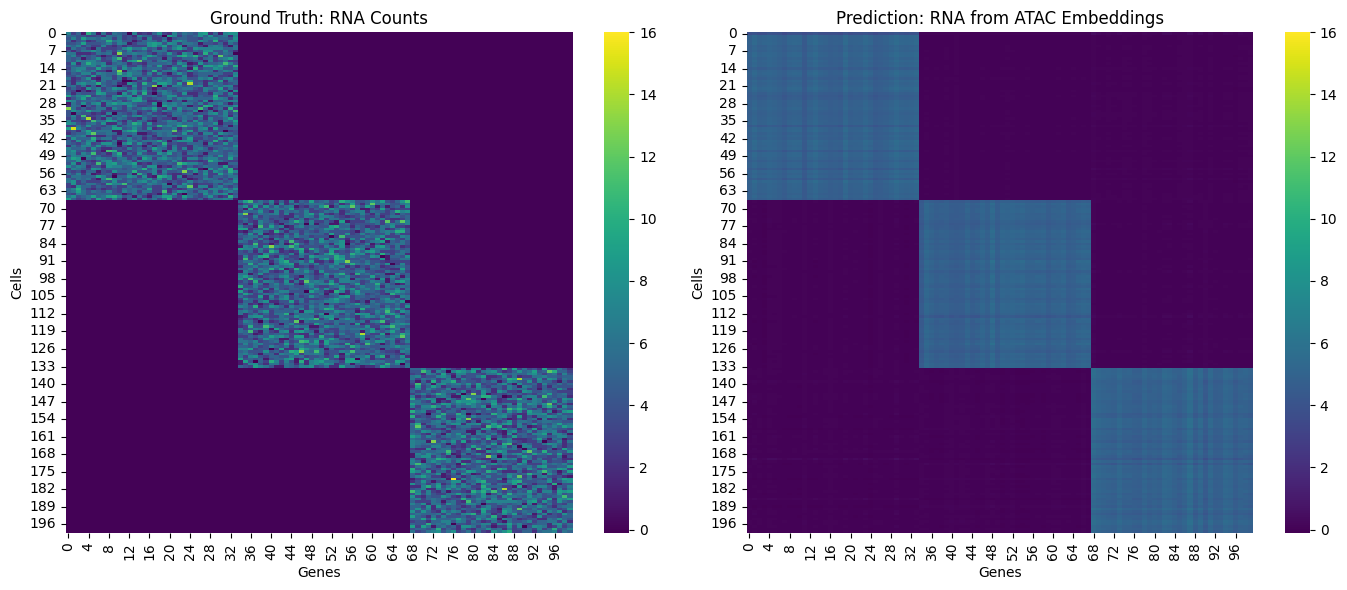

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch
def visualize_rna_reconstruction_heatmap(model, adata_rna, adata_atac,
                                         zero_inflate=1,
                                         conn_name='conn0', feat_name='feat0'):
    """
    Visualizes the reconstructed/predicted RNA matrix as a heatmap.
    Uses ATAC embeddings to predict RNA (Cross-Modality check).
    """
    print("Generating RNA prediction heatmap...")
    # 1. Prepare Source Embeddings (ATAC cells)
    # The cache stores [RNA_cells, ATAC_cells] in order.
    # We use ATAC embeddings to predict RNA to test integration.
    n_rna = adata_rna.n_obs
    n_atac = adata_atac.n_obs
    all_emb = model.cache['saved_embeddings']['cell']
    atac_emb = all_emb[n_rna : n_rna + n_atac] # Select ATAC part
    # 2. Run Prediction
    # We predict 'feat0' (RNA genes) using 'conn0' logic
    pred_data = pred_from_AnnData(atac_emb, adata_rna, zero_inflate, conn_name, feat_name)
    pred_data['cell'].x = pred_data['cell'].x.to(torch.float32)
    model.cpu()
    pred_data = pred_data.to("cpu")
    with torch.no_grad():
        preds = predict(model, pred_data)
    # 3. Extract and Reshape Prediction
    pred_key = f"cell-{conn_name}-{feat_name}"
    if zero_inflate == 1:
        # Index 1 = Expression Value (Regression), Index 0 = Dropout Probability
        pred_flat = preds[pred_key][1].detach().numpy()
    else:
        pred_flat = preds[pred_key].detach().numpy()
    # Reshape: (N_cells, N_genes)
    rna_pred_matrix = pred_flat.reshape(adata_rna.n_obs, adata_rna.n_vars)
    # 4. Plotting
    if hasattr(adata_rna.X, "toarray"):
        truth_mat = adata_rna.X.toarray()
    else:
        truth_mat = adata_rna.X

    g_min = min(truth_mat.min(), rna_pred_matrix.min())
    g_max = max(truth_mat.max(), rna_pred_matrix.max())
    
    # 4. Plotting
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # Ground Truth
    sns.heatmap(
        adata_rna.X, 
        cmap="viridis", 
        cbar=True, 
        ax=ax[0],
        vmin=g_min, vmax=g_max  # Set limits
    )
    ax[0].set_title("Ground Truth: RNA Counts")
    ax[0].set_xlabel("Genes")
    ax[0].set_ylabel("Cells")
    
    # Prediction
    sns.heatmap(
        rna_pred_matrix, 
        cmap="viridis", 
        cbar=True, 
        ax=ax[1],
        vmin=g_min, vmax=g_max  # Set limits
    )
    ax[1].set_title("Prediction: RNA from ATAC Embeddings")
    ax[1].set_xlabel("Genes")
    ax[1].set_ylabel("Cells")
    
    plt.tight_layout()
    plt.show()

# --- Execution ---
if __name__ == "__main__":
    # Ensure this runs after your training loop
    visualize_rna_reconstruction_heatmap(
        model,
        adata_rna,
        adata_atac,
        zero_inflate=ZERO1,  # Use the RNA zero-inflation flag
        conn_name='conn0',   # Connection name for RNA (usually 0)
        feat_name='feat0'    # Feature name for RNA (usually 0)
    )


Running UMAP on Enhanced/Refined Embeddings...


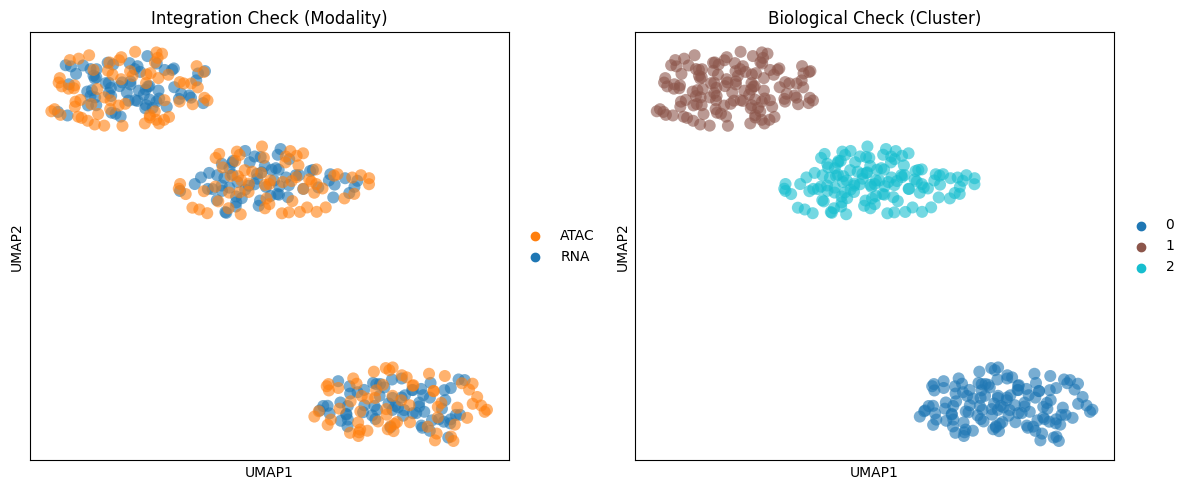

In [27]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

def visualize_enhanced_umap(enh_rna, enh_atac, adata_rna, adata_atac):
    """
    Concatenates enhanced/refined embeddings and runs UMAP to visualize integration.
    """
    print("Running UMAP on Enhanced/Refined Embeddings...")
    
    # 1. Concatenate Embeddings
    # enh_rna and enh_atac are DataFrames (cells x features)
    joint_emb = pd.concat([enh_rna, enh_atac], axis=0)
    
    # 2. Create a temporary AnnData object for Scanpy processing
    adata_vis = sc.AnnData(X=joint_emb.values)
    adata_vis.obs_names = joint_emb.index
    
    # 3. Add Metadata for Plotting
    # Modality Labels
    adata_vis.obs['Modality'] = (['RNA'] * enh_rna.shape[0]) + (['ATAC'] * enh_atac.shape[0])
    
    # Cluster Labels (Map from original objects)
    # This assumes indices match, which they should from the pipeline
    rna_clusters = adata_rna.obs['cluster']
    atac_clusters = adata_atac.obs['cluster']
    adata_vis.obs['Cluster'] = pd.concat([rna_clusters, atac_clusters]).values
    
    # 4. Run UMAP Pipeline
    # Since inputs are already PCA/Embeddings, we use them directly for neighbors
    # use_rep='X' tells Scanpy to use the .X matrix (our embeddings) as the latent representation
    sc.pp.neighbors(adata_vis, use_rep='X', n_neighbors=15)
    sc.tl.umap(adata_vis)
    
    # 5. Plot Side-by-Side
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot A: By Modality (Check Integration)
    sc.pl.umap(
        adata_vis, 
        color='Modality', 
        ax=axs[0], 
        show=False, 
        title="Integration Check (Modality)",
        palette={'RNA': '#1f77b4', 'ATAC': '#ff7f0e'}, # Blue/Orange
        alpha=0.6
    )
    
    # Plot B: By Cluster (Check Biology)
    sc.pl.umap(
        adata_vis, 
        color='Cluster', 
        ax=axs[1], 
        show=False, 
        title="Biological Check (Cluster)",
        palette="tab10",
        alpha=0.6
    )
    
    plt.tight_layout()
    plt.show()

# --- Execution ---
if __name__ == "__main__":
    # Ensure enh_rna and enh_atac are available from the pipeline output
    visualize_enhanced_umap(enh_rna, enh_atac, adata_rna, adata_atac)